# <center><font color=#10e2e6>Kaggle Playground: Predicting Concrete Strength</font></center>

##### <center>This notebook attempts to use machine learning to predict concrete strength from the Kaggle Playground series. I used this mainly as an attempt to better understand machine learning concepts, so there was a lot of manual changes of parameters to see how they affect the predictions. Throughout the notebook I will try to explain as much as I can what each part is and what it is doing. </center>

## <center>Table of Contents</center>
* [The Baseline](#baseline)
* [TensorFlow: Keras](#tensorflow)
* [XGBoost](#xgboost)
* [Scikit Learn: GradientBoostingRegressor](#gbr)
* [LightGBM](#lgbm)
* [CatBoost](#cb)
* [Averaging The Models](#average)
  * [The Best Model](#best)
  * [The Other Attempts](#others)

##  <div id='baseline'/><center><font color=#ed4588>The Baseline</center></font>

<center>Here I just wanted to get a baseline on what the predictions should be better than. The first codeblock just imports pandas, numpy and matplotlib which I will use throughout the notebook.</center>

In [603]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

train = pd.read_csv('/Users/poodle/Data Science Projects/playground-series-s3e9/train.csv')
test = pd.read_csv('/Users/poodle/Data Science Projects/playground-series-s3e9/test.csv')

train

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...,...
5402,5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


It is important to check the data type of each columns because regrssors do not work with categorical data, so we need to know beforehand if we need to change the categories into numerical data or drop them. As we can see below, all of the data is either an integer or a decimal so we can proceed without any manipulation.

In [604]:
train.dtypes

id                             int64
CementComponent              float64
BlastFurnaceSlag             float64
FlyAshComponent              float64
WaterComponent               float64
SuperplasticizerComponent    float64
CoarseAggregateComponent     float64
FineAggregateComponent       float64
AgeInDays                      int64
Strength                     float64
dtype: object

From there we need to split the data into training and validation for machine learning. the X data will include everything but the id and 'Strength' column, the 'id' column is dropped because it has no effect on the strength of the concrete and the 'Strength' column is dropped because that is the column we are trying to predict. the y data will include only the 'Strength' column.

In [605]:
from sklearn.model_selection import train_test_split
X = train.drop(['Strength', 'id'], axis=1)
y = train['Strength']

#the test size determines the proportion of the data split, meaning that X_test and y_test will be 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=.2)

Now we start with a basic linear regression. The error metric used in this project is mean squared error, our main goal will be to get that number as low as possible without overfitting the data. No need to try anything fancy right now, this is simply to find a baseline to know if we are headed in the right direction.

In [606]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

predictions = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, predictions))

MSE:  218.32186092635655


The code here is just how you can put your predictions into a dataset that can be submitted to Kaggle. You will see this block of code more and it just means that I did upload it to Kaggle for a score.

In [607]:
sublesson = pd.DataFrame()
sublesson['id'] = test.id

feats = test.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = model.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,35.998492
1,5408,27.134653
2,5409,26.880632
3,5410,39.188943
4,5411,32.553797
...,...,...
3600,9007,32.631893
3601,9008,28.550604
3602,9009,35.353478
3603,9010,53.952081


Standardscaler is a processing technique for datasets that is commonly required for machine learning, this standardizes the data, changing the values so that the distribution is Gaussian. 

In [608]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(ss.fit_transform(X_test),columns=X_test.columns)
test_scaled = pd.DataFrame(ss.fit_transform(test),columns=test.columns)

In [609]:
lr = linear_model.LinearRegression()
model = lr.fit(X_train_scaled, y_train)

predictions = model.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, predictions))

MSE:  218.78721250153671


In [610]:
feats = test_scaled.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = model.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,36.180932
1,5408,26.888105
2,5409,26.823765
3,5410,39.731289
4,5411,32.369181
...,...,...
3600,9007,32.485205
3601,9008,28.516760
3602,9009,35.287175
3603,9010,53.322940


Here is the 'Public Score,' which Kaggle is using 'root mean square error' to rank the predictions with their dataset (I am currently using mean squared, which is the same error metric without the square rooting). The lower the score, the better the predictions were.

In [611]:
print('Public Score: 14.09124')

Public Score: 14.09124


Here we use Ridge which seems to not be a better predictor than the normal linear regression we did previously. Which from my rudimentary understanding makes sense since this regressor seems to be used when the loss function is 'Linear Least Squares' according to the scikit learn documentation

>This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization. This estimator has built-in support for multi-variate regression (i.e., when y is a 2d-array of shape (n_samples, n_targets)).

In [612]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)
reg.fit(X_train_scaled, y_train)
predictions = reg.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, predictions))

MSE:  218.78697273456558


In [613]:
sublesson = pd.DataFrame()
sublesson['id'] = test.id

feats = test.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = reg.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,366.255383
1,5408,92.098762
2,5409,-22.633087
3,5410,661.448880
4,5411,42.770109
...,...,...
3600,9007,173.714966
3601,9008,153.316686
3602,9009,500.098289
3603,9010,940.049969


In [614]:
print('Public Score: 14.12065')

Public Score: 14.12065


## <div id='tensorflow'><center><font color=#f09b3a>TensorFlow: Keras</font></center>

Tensorflow is another form a machine learning which uses neural networks that can be trained to recognize patterns. Here I have tried a few different models using Keras to see which ones would be most effective and bring out the best results.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

input_shape = [X_train.shape[1]]

SyntaxError: invalid syntax (pywrap_tensorflow_internal.py, line 114)

So here we have created a Keras model with three different types of layers: Dense, BatchNormalization, and Dropout. 
>Dense: Just your regular densely-connected NN layer.

>BatchNormalization: Layer that normalizes its inputs. 
>Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
>Importantly, batch normalization works differently during training and during inference.

>Dropout: Applies Dropout to the input. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

In [616]:
model = keras.Sequential([
    #512 indicates how many 'neurons' we want. 'activation' sets the function to use, which it is set to  'relu' also known as 'Rectified Linear Unit'. 
    #'input_shape' is set to how many columns are in the training dataset
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    #rate is the frequency it sets inputs to 0, in this case 30% of the time.
    layers.Dropout(rate=.3),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(1)
])

Epoch 1/50
9/9 [==============================] - 4s 53ms/step - loss: 1468.1664 - val_loss: 1504.6627
Epoch 2/50
9/9 [==============================] - 0s 30ms/step - loss: 1403.3523 - val_loss: 1458.2726
Epoch 3/50
9/9 [==============================] - 0s 25ms/step - loss: 1370.0432 - val_loss: 1378.9926
Epoch 4/50
9/9 [==============================] - 0s 35ms/step - loss: 1337.6946 - val_loss: 1312.9324
Epoch 5/50
9/9 [==============================] - 0s 38ms/step - loss: 1299.6080 - val_loss: 1231.7854
Epoch 6/50
9/9 [==============================] - 0s 38ms/step - loss: 1260.8069 - val_loss: 1166.3282
Epoch 7/50
9/9 [==============================] - 0s 31ms/step - loss: 1208.0154 - val_loss: 1074.8004
Epoch 8/50
9/9 [==============================] - 0s 38ms/step - loss: 1147.5767 - val_loss: 994.9750
Epoch 9/50
9/9 [==============================] - 0s 33ms/step - loss: 1075.5847 - val_loss: 885.0123
Epoch 10/50
9/9 [==============================] - 0s 26ms/step - loss: 998

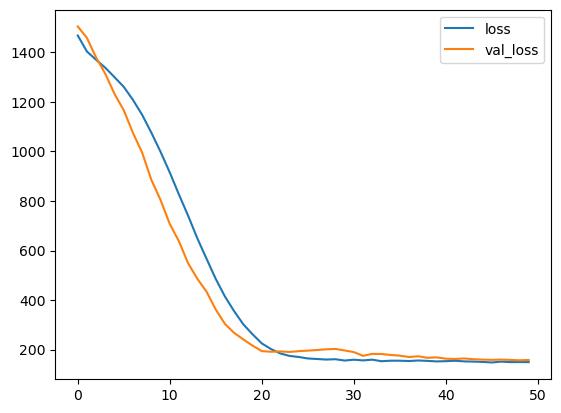

In [617]:
model.compile(
    #'optimizer' is the algorithm the model uses for optimization, currently set to 'Adam' which is a stochastic gradient descent method
    optimizer='adam',
    #'loss' sets the metric the model uses, currently set to mean squared error
    loss='mse'
)

early_stopping = keras.callbacks.EarlyStopping(
    #'patience' is the number of epochs with no improvement the model will stop, currently set to 5 epochs 
    patience=5,
    #'monitor' the quantity to monitor for improvement, currently set to validation loss
    monitor='val_loss',
    #'resotre_best_weights' restores the best model weights from the epoch with the lowest validation loss
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    #'batch_size' is how many data points to use for each training session
    batch_size=512,
    #'epochs' is how many times to train the model
    epochs=50,
    verbose=1
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print('Minimum Validation Loss: {:0.4f}'.format(history_df['val_loss'].min()))

In [618]:
predictions = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, predictions))

34/34 [==============================] - 0s 1ms/step
MSE:  3887668.3436720534


In [619]:
feats = test.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = model.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

113/113 [==============================] - 0s 3ms/step


,id,Strength
0,5407,2331.615479
1,5408,1642.854370
2,5409,1917.974976
3,5410,2573.771729
4,5411,2240.795654
...,...,...
3600,9007,1605.226196
3601,9008,2149.487793
3602,9009,1758.515747
3603,9010,1169.619873


In [620]:
print("Public Score: 12.42997")

Public Score: 12.42997


This time around the I lowered the number of neurons in the dense layer from 512 to 256, and then cut it in half to 128. Doing this to see if the previous model was too many neurons for this amount of data. I also lowered the batch size to see how that affects MSE

In [621]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.1),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.1),
    layers.BatchNormalization(),
    layers.Dense(1)
])

Epoch 1/50
17/17 [==============================] - 2s 19ms/step - loss: 35.3043 - val_loss: 35.1837
Epoch 2/50
17/17 [==============================] - 0s 7ms/step - loss: 34.9645 - val_loss: 34.7085
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 34.5075 - val_loss: 33.9388
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 33.9029 - val_loss: 33.0934
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 33.1364 - val_loss: 32.1666
Epoch 6/50
17/17 [==============================] - 0s 7ms/step - loss: 32.1964 - val_loss: 31.0465
Epoch 7/50
17/17 [==============================] - 0s 7ms/step - loss: 31.0688 - val_loss: 29.6246
Epoch 8/50
17/17 [==============================] - 0s 7ms/step - loss: 29.7519 - val_loss: 28.1103
Epoch 9/50
17/17 [==============================] - 0s 7ms/step - loss: 28.2557 - val_loss: 26.5992
Epoch 10/50
17/17 [==============================] - 0s 7ms/step - loss: 26.5914 - val_loss: 24.646

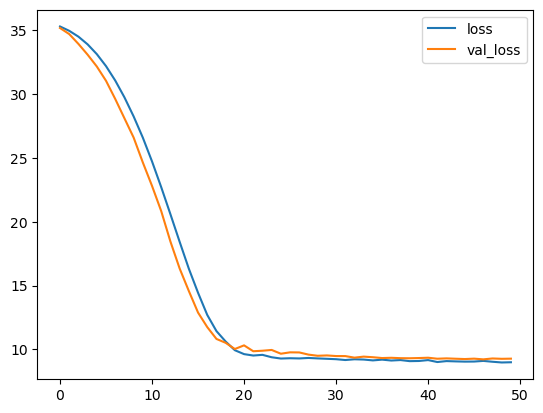

In [622]:
model.compile(
    optimizer='adam',
    loss='mae'
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_loss',
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=256,
    epochs=50,
    verbose=1
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print('Minimum Validation Loss: {:0.4f}'.format(history_df['val_loss'].min()))

In [623]:
predictions = model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(y_test, predictions))

34/34 [==============================] - 0s 3ms/step
MSE:  149.35493930682833


In [624]:
feats = test_scaled.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = model.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

113/113 [==============================] - 0s 2ms/step


,id,Strength
0,5407,43.105988
1,5408,18.479713
2,5409,33.709209
3,5410,46.066113
4,5411,24.936083
...,...,...
3600,9007,36.305019
3601,9008,32.815266
3602,9009,38.480759
3603,9010,33.862015


In [625]:
print('Public Score: 12.3356')

Public Score: 12.3356


This time around I added one more set of dense, dropout, and batchnormalization layers.

In [626]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Epoch 1/50
34/34 [==============================] - 3s 13ms/step - loss: 1475.8253 - val_loss: 1492.9891
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 1405.5402 - val_loss: 1395.2378
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 1330.6335 - val_loss: 1195.0208
Epoch 4/50
34/34 [==============================] - 0s 7ms/step - loss: 1255.6763 - val_loss: 1014.1267
Epoch 5/50
34/34 [==============================] - 0s 7ms/step - loss: 1169.9337 - val_loss: 933.5942
Epoch 6/50
34/34 [==============================] - 0s 7ms/step - loss: 1074.6976 - val_loss: 899.8416
Epoch 7/50
34/34 [==============================] - 0s 7ms/step - loss: 969.3555 - val_loss: 859.4637
Epoch 8/50
34/34 [==============================] - 0s 7ms/step - loss: 858.5419 - val_loss: 792.7110
Epoch 9/50
34/34 [==============================] - 0s 7ms/step - loss: 734.4295 - val_loss: 675.1774
Epoch 10/50
34/34 [==============================] - 0s 7ms/step - loss

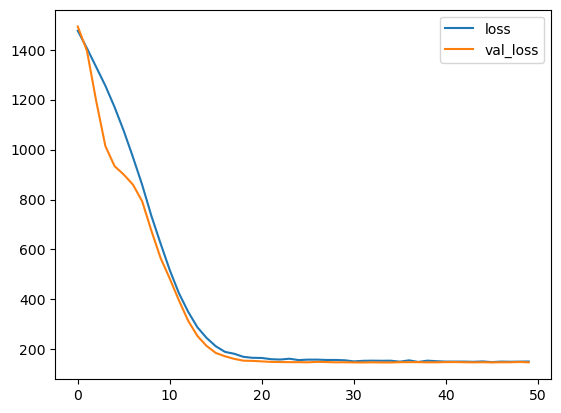

In [627]:
model.compile(
    optimizer='adam',
    loss='mse'
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_loss',
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=128,
    epochs=50,
    verbose=1
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print('Minimum Validation Loss: {:0.4f}'.format(history_df['val_loss'].min()))

In [628]:
predictions = model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(y_test, predictions))

34/34 [==============================] - 0s 861us/step
MSE:  148.02724679796506


In [629]:
feats = test_scaled.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = model.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

113/113 [==============================] - 0s 1ms/step


,id,Strength
0,5407,50.154804
1,5408,17.965900
2,5409,34.522923
3,5410,46.860111
4,5411,30.339481
...,...,...
3600,9007,35.521809
3601,9008,34.398777
3602,9009,37.805080
3603,9010,37.830914


This was the best score I was able to get with tensorflow, I did a lot of other combinations in another notebook but these three shows a good progression of the score as I change certain parameters

In [630]:
print('Public Score: 12.25249')

Public Score: 12.25249


In [631]:
from sklearn.neighbors import KNeighborsRegressor, kneighbors_graph

knn = KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='kd_tree', leaf_size=50)
model = knn.fit(X_train, y_train)

predictions = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, predictions))

MSE:  176.16345588170054


## <div id='xgboost'><center><font color=#3cf224>XGBoost</font></center>

XGBoost (eXtreme Gradient Boosting) is a very popular model of machine learning, which uses a gradient boosting algorithm. This model showed by far the best results off the bat compared to all the other models I tested by themselves. 

In [632]:
import xgboost as xgb

#'n_estimators' is how many trees will be created. 'max_depth' increases the depth of a tree, this makes the model more complex and more likely to overfit. 
#'learning_rate' is a tool to prevent overfitting, it shrinks the weights after each step to make the process more conservative.
xgbr = xgb.XGBRegressor(n_estimators=10, learning_rate=.35, max_depth=3, verbosity=1)
xgbr.fit(X_train_scaled, y_train)

print('Score: ',xgbr.score(X_train_scaled, y_train))

predictions = xgbr.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, predictions))

Score:  0.46876675610780183
MSE:  147.19188188910258


In [633]:
feats = test_scaled.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = xgbr.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,48.326336
1,5408,19.221888
2,5409,34.295856
3,5410,46.467617
4,5411,32.198212
...,...,...
3600,9007,33.942581
3601,9008,35.940357
3602,9009,38.107155
3603,9010,31.432680


In [634]:
print('Public Score: 11.75791')

Public Score: 11.75791


In [635]:
#'gamma' is the minimum loss reduction to make another leaf on the tree, the higher the gamma, the more conservative the algorithm. 
xgbr = xgb.XGBRegressor(gamma=600, n_estimators=10, learning_rate=.35, max_depth=3, verbosity=1)
xgbr.fit(X_train_scaled, y_train)

print('Score: ',xgbr.score(X_train_scaled, y_train))

predictions = xgbr.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, predictions))

Score:  0.46786730885912786
MSE:  146.79947397491986


In [636]:
feats = test_scaled.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = xgbr.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,48.325768
1,5408,19.221994
2,5409,34.295963
3,5410,46.467049
4,5411,32.199360
...,...,...
3600,9007,33.943729
3601,9008,35.940464
3602,9009,38.107262
3603,9010,31.293776


In [637]:
print('Public Score: 11.76691')

Public Score: 11.76691


## <div id='gbr'><center><font color=#dd48f7>Scikit Learn: GradientBoostingRegressor</font></center>

Sci-kit Learn's GradientBoosting Regressor is an algorithm that is similar to the one's before, with each stage of the regression stage fitted to the negative gradient of the given loss function, in this case squared_error.

In [638]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=89, loss='squared_error', learning_rate=.05, random_state=0, max_depth=4)
gbr.fit(X_train_scaled, y_train)

predictions = gbr.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, predictions))

MSE:  147.23753405499082


In [639]:
feats = test_scaled.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = gbr.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,51.025676
1,5408,19.796177
2,5409,35.030220
3,5410,46.696810
4,5411,33.070301
...,...,...
3600,9007,31.929911
3601,9008,35.881958
3602,9009,38.338107
3603,9010,32.915040


In [640]:
predictions = (xgbr.predict(feats) + gbr.predict(feats)) / 2

In [641]:
sublesson['id'] = test.id
sublesson['Strength'] = predictions

sublesson.to_csv('PS_S3E9.csv', index=False)

## <div id='lgbm'><center><font color=#dd48f7>LightGBM</center></font>

LightGBM is another gradient boosting framework, so we should expect similar scores as before. The selling points of this algorithm are:
> * Faster training speed and higher efficiency.
> * Lower memory usage.
> * Better accuracy.
> * Support of parallel, distributed, and GPU learning.
> * Capable of handling large-scale data.

In [642]:
import lightgbm as lgb

#'max_bin'is a way to reduce training time, reducing the number of bins, the faster the training. 'reg_alpha' and 'reg_lambda' are used for 'regularization' and prevent overfitting, 
lgbr = lgb.LGBMRegressor(max_depth=2, learning_rate=.1, max_bin=7, metric='mse', reg_alpha=.1, reg_lambda=.9)
lgbr.fit(X_train_scaled, y_train)
predictions = lgbr.predict(X_test_scaled)
print('MSE: ', mean_squared_error(y_test, predictions))

MSE:  146.0853462973969


In [643]:
feats = test_scaled.select_dtypes(include=[np.number]).drop(['id'], axis=1).interpolate()
predictions = lgbr.predict(feats)

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,47.315508
1,5408,18.848255
2,5409,34.600733
3,5410,46.672820
4,5411,34.533948
...,...,...
3600,9007,34.256957
3601,9008,35.940193
3602,9009,38.466602
3603,9010,29.831882


In [644]:
print('Public Score: 11.77813')

Public Score: 11.77813


## <div id='cb'><center><font color=#f79448>CatBoost</font></center>

Catboost according to the official documentation 
> is a machine learning algorithm that uses gradient boosting on decision trees.

One of the selling points of this algoritm is that you do not need to do a lot of parameter tuning for this algorithm to be effective.

In [645]:
import catboost as cb

#'max_bin' changes the number of splits for numerical features
cbr = cb.CatBoostRegressor(learning_rate=.01, loss_function='RMSE', n_estimators=1000, max_bin=1024)
cbr.fit(X_train_scaled, y_train)
predictions = cbr.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, predictions))

0:	learn: 16.2919556	total: 5.17ms	remaining: 5.16s
1:	learn: 16.2253627	total: 8.25ms	remaining: 4.12s
2:	learn: 16.1631193	total: 9.93ms	remaining: 3.3s
3:	learn: 16.0994484	total: 11.8ms	remaining: 2.94s
4:	learn: 16.0384340	total: 13.3ms	remaining: 2.64s
5:	learn: 15.9763974	total: 14.8ms	remaining: 2.45s
6:	learn: 15.9155644	total: 16.2ms	remaining: 2.29s
7:	learn: 15.8597344	total: 17.4ms	remaining: 2.16s
8:	learn: 15.7997282	total: 19.1ms	remaining: 2.1s
9:	learn: 15.7421516	total: 20.8ms	remaining: 2.06s
10:	learn: 15.6845432	total: 22.3ms	remaining: 2s
11:	learn: 15.6269614	total: 24.4ms	remaining: 2.01s
12:	learn: 15.5722865	total: 26.1ms	remaining: 1.98s
13:	learn: 15.5177659	total: 27.8ms	remaining: 1.96s
14:	learn: 15.4614251	total: 29ms	remaining: 1.91s
15:	learn: 15.4089438	total: 30.9ms	remaining: 1.9s
16:	learn: 15.3545437	total: 32.4ms	remaining: 1.88s
17:	learn: 15.3004198	total: 34ms	remaining: 1.86s
18:	learn: 15.2484297	total: 35.2ms	remaining: 1.82s
19:	learn: 15

## <div id='average'><center><font color=#585bf5>Averaging The Models</center></font>

Here I do not try anything new for the models, I just add them together and divde them to get the average and see how that affects the score, I do get my best score out of these averages, but knowing which one did best did not really seem to have a discernable reason, since as I lowered and lowered the mean squared error, I actually ended up getting a worse score.

## <div id='best'><center><font color=#fce238>The Best Model</font></center>

In [646]:
predictions_lgbr = lgbr.predict(X_test_scaled)
predictions_xgbr = xgbr.predict(X_test_scaled)

predictions = (predictions_lgbr + predictions_xgbr) / 2

print('MSE: ', mean_squared_error(y_test, predictions))

MSE:  145.72581382016517


In [647]:
predictions_lgbr = lgbr.predict(feats)
predictions_xgbr = xgbr.predict(feats)

predictions = (predictions_lgbr + predictions_xgbr) / 2

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,47.820638
1,5408,19.035125
2,5409,34.448348
3,5410,46.569934
4,5411,33.366654
...,...,...
3600,9007,34.100343
3601,9008,35.940329
3602,9009,38.286932
3603,9010,30.562829


In [648]:
print('Public Score: 11.74601')

Public Score: 11.74601


The combination above ended up being the one with the lowest public score and ranked me the highest in the competition. After this you will see lower scores even though the error metric did get smaller. This may be a sign of overfitting. However, I decided to include it in this notebook because I think it is important to show that more is not always better.

## <div id='others'><center><font color=#f03a5e>The Other Attempts</font></center>

In [649]:
predictions_lgbr = lgbr.predict(X_test_scaled)
predictions_xgbr = xgbr.predict(X_test_scaled)
predictions_cbr = cbr.predict(X_test_scaled)

predictions = (predictions_lgbr + predictions_xgbr + predictions_cbr) / 3

print('MSE: ', mean_squared_error(y_test, predictions))

predictions.shape

MSE:  145.2472771855387


(1082,)

In [650]:
predictions_lgbr = lgbr.predict(feats)
predictions_xgbr = xgbr.predict(feats)
predictions_cbr = cbr.predict(feats)

predictions = (predictions_lgbr + predictions_xgbr + predictions_cbr) / 3

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,48.452667
1,5408,19.078657
2,5409,34.520782
3,5410,46.773091
4,5411,32.581062
...,...,...
3600,9007,33.853467
3601,9008,35.899165
3602,9009,38.682490
3603,9010,32.166798


In [651]:
print('Public Score: 11.75658')

Public Score: 11.75658


In [652]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Epoch 1/50
17/17 [==============================] - 2s 24ms/step - loss: 35.3456 - val_loss: 35.3541
Epoch 2/50
17/17 [==============================] - 0s 15ms/step - loss: 35.1255 - val_loss: 35.1052
Epoch 3/50
17/17 [==============================] - 0s 9ms/step - loss: 34.8463 - val_loss: 34.7701
Epoch 4/50
17/17 [==============================] - 0s 9ms/step - loss: 34.4928 - val_loss: 34.4919
Epoch 5/50
17/17 [==============================] - 0s 9ms/step - loss: 34.0598 - val_loss: 34.1522
Epoch 6/50
17/17 [==============================] - 0s 13ms/step - loss: 33.5432 - val_loss: 33.6004
Epoch 7/50
17/17 [==============================] - 0s 10ms/step - loss: 32.9360 - val_loss: 32.8622
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 32.2363 - val_loss: 32.3729
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 31.4521 - val_loss: 31.4473
Epoch 10/50
17/17 [==============================] - 0s 9ms/step - loss: 30.5642 - val_loss: 29.

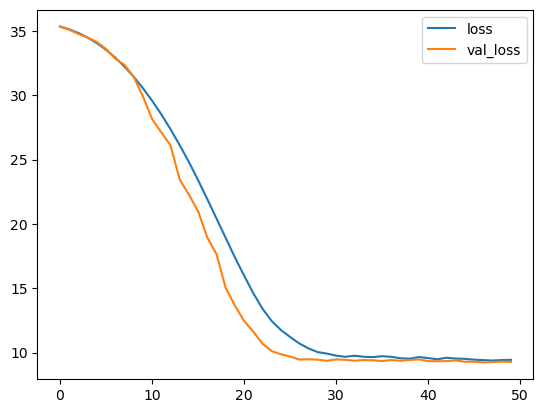

In [653]:
model.compile(
    optimizer='adam',
    loss='mae'
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_loss',
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=256,
    epochs=50,
    verbose=1
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print('Minimum Validation Loss: {:0.4f}'.format(history_df['val_loss'].min()))

In [654]:
predictions = model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(y_test, predictions))

predictions = predictions.resize(1082,1)

34/34 [==============================] - 0s 2ms/step
MSE:  150.91614023562195


In [655]:
gbr = GradientBoostingRegressor(n_estimators=89, loss='squared_error', learning_rate=.05, random_state=0, max_depth=4)
gbr.fit(X_train_scaled, y_train)

predictions = gbr.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, predictions))

MSE:  147.23753405499082


In [656]:
predictions_lgbr = lgbr.predict(X_test_scaled)
predictions_xgbr = xgbr.predict(X_test_scaled)
predictions_cbr = cbr.predict(X_test_scaled)
predictions_gbr = gbr.predict(X_test_scaled)
predictions_tf = model.predict(X_test_scaled)
predictions_tf = predictions_tf.tolist()
predictions_tf = sum(predictions_tf, [])
predictions_tf = np.asarray(predictions_tf)

predictions = (predictions_lgbr + predictions_xgbr + predictions_cbr + predictions_tf) / 4

print('MSE: ', mean_squared_error(y_test, predictions))

34/34 [==============================] - 0s 3ms/step
MSE:  145.32464816919742


In [657]:
predictions_lgbr = lgbr.predict(feats)
predictions_xgbr = xgbr.predict(feats)
predictions_cbr = cbr.predict(feats)
predictions_gbr = gbr.predict(feats)
predictions_tf = model.predict(feats)
predictions_tf = predictions_tf.tolist()
predictions_tf = sum(predictions_tf, [])
predictions_tf = np.asarray(predictions_tf)

predictions = (predictions_lgbr + predictions_xgbr + predictions_cbr + predictions_tf + predictions_gbr) / 5

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

113/113 [==============================] - 0s 2ms/step


,id,Strength
0,5407,48.826726
1,5408,18.707138
2,5409,33.981949
3,5410,46.687184
4,5411,32.470960
...,...,...
3600,9007,33.822585
3601,9008,35.237507
3602,9009,38.136340
3603,9010,31.851634


In [658]:
print('Public Score: 11.79047')

Public Score: 11.79047


In [659]:
predictions_lgbr = lgbr.predict(X_test_scaled)
predictions_xgbr = xgbr.predict(X_test_scaled)
predictions_cbr = cbr.predict(X_test_scaled)
predictions_gbr = gbr.predict(X_test_scaled)
predictions_tf = model.predict(X_test_scaled)
predictions_tf = predictions_tf.tolist()
predictions_tf = sum(predictions_tf, [])
predictions_tf = np.asarray(predictions_tf)

predictions = (predictions_cbr + predictions_xgbr + predictions_gbr) / 3

print('MSE: ', mean_squared_error(y_test, predictions))

34/34 [==============================] - 0s 3ms/step
MSE:  145.71939831057588


In [660]:
predictions_lgbr = lgbr.predict(feats)
predictions_xgbr = xgbr.predict(feats)
predictions_cbr = cbr.predict(feats)
predictions_gbr = gbr.predict(feats)
predictions = (predictions_xgbr + predictions_xgbr + predictions_gbr) / 3

sublesson['Strength'] = predictions
sublesson.to_csv('PS_S3E9.csv', index=False)

sublesson

,id,Strength
0,5407,49.225737
1,5408,19.413389
2,5409,34.540716
3,5410,46.543636
4,5411,32.489674
...,...,...
3600,9007,33.272457
3601,9008,35.920962
3602,9009,38.184210
3603,9010,31.834197
